## This notebook contains all neo4j queries to create the graph data model on twitter data.

### Tweet Node
CALL apoc.periodic.iterate(  
'CALL apoc.load.json("file:///tweets_clean.json") YIELD value',  
'WITH  
value.id AS id,  
datetime({ epochMillis: apoc.date.parse(value.postedTime, "ms",  
    "yyyy-MM-dd\'T\'HH:mm:ss.SSS\'Z\'")}) AS postedTimestamp,  
value.text AS text,  
value.twitter_lang AS language,  
value.retweetCount AS retweetCount,  
value.favoritesCount AS favoritesCount,  
value.verb AS retweets  
MERGE (t:Tweet{id:id})  
ON CREATE SET  
t.postedTimestamp = postedTimestamp,  
t.text = text,  
t.language = language,  
t.retweetCount = retweetCount,  
t.favoritesCount = favoritesCount,  
t.retweetStatus = retweets',  
{batchSize:500})  
YIELD * ;

### User Node and POSTS relationship
CALL apoc.periodic.iterate(  
'CALL apoc.load.json("file:///tweets_clean.json") YIELD value',  
'WITH value  
MATCH (t:Tweet{id:value.id})  
WITH t, value  
UNWIND value.actor AS user  
MERGE (u:User{id:user.id})  
ON CREATE SET  
u.officialName = user.displayName,  
u.twitterName = user.preferredUsername,  
u.userLink = user.link  
MERGE (u)-[:POSTS]->(t)',  
{batchSize:500})  
YIELD * ;

### Source Node and USING relationship
CALL apoc.periodic.iterate(  
'CALL apoc.load.json("file:///tweets_clean.json") YIELD value',  
'WITH value  
MATCH (t:Tweet{id:value.id})  
WITH t, value  
UNWIND value.generator AS source  
MERGE (s:Source {sourceName:source.displayName})  
ON CREATE SET  
s.sourceLink = source.link  
MERGE (t)-[:USING]->(s)',  
{batchSize:500})  
YIELD * ;

### Hashtag Node and TAGS relationship
CALL apoc.periodic.iterate(  
'CALL apoc.load.json("file:///tweets_clean.json") YIELD value',  
'WITH value  
MATCH (t:Tweet{id:value.id})  
WITH t, value  
UNWIND value.twitter_entities AS level1  
FOREACH (tag in level1.hashtags |  
    MERGE (h:Hashtag {hashtag:tag.text})  
    MERGE (t)-[:TAGS]->(h))',  
{batchSize:500})  
YIELD * ;

### Retweet Node and RETWEET and TAGS relationship
CALL apoc.periodic.iterate(  
'CALL apoc.load.json("file:///tweets_clean.json") YIELD value',  
'WITH value  
MATCH (t:Tweet{id:value.id})  
WHERE t.retweetStatus = "share"  
WITH t, value  
UNWIND value.object AS retweet  
MERGE (rt:Retweet {id:retweet.id})  
ON CREATE SET  
rt.retweetStatus = retweet.verb,  
rt.postedTime = datetime({ epochMillis: apoc.date.parse(retweet.postedTime, "ms",  
"yyyy-MM-dd\'T\'HH:mm:ss.SSS\'Z\'")}),  
rt.link = retweet.link,  
rt.text = retweet.text,  
rt.favoritesCount = retweet.favoritesCount  
MERGE (t)-[:RETWEETS]->(rt)  
WITH rt, value, retweet  
UNWIND retweet.twitter_entities AS level2  
FOREACH (tag in level2.hashtags |  
    MERGE (h:Hashtag {hashtag:tag.text})  
    MERGE (rt)-[:TAGS]->(h))',  
{batchSize:500})  
YIELD * ;

### Mentioned User Node and MENTIONS relationship
CALL apoc.periodic.iterate(  
'CALL apoc.load.json("file:///tweets_clean.json") YIELD value',  
'WITH value  
MATCH (t:Tweet{id:value.id})  
WITH t, value  
UNWIND value.twitter_entities AS level1  
FOREACH (user in level1.user_mentions |  
    MERGE (u:mentionedUser {name:user.name})  
    ON CREATE SET  
        u.twitterName = user.screen_name,  
        u.id = user.id  
    MERGE (t)-[:MENTIONS]->(u))',  
{batchSize:500})  
YIELD * ;

### Link Node and CONTAINS relationship
CALL apoc.periodic.iterate(  
'CALL apoc.load.json("file:///tweets_clean.json") YIELD value',  
'WITH  
    value.link AS link,  
    value.id AS id  
MATCH(t:Tweet{id:id})  
MERGE (l:Link{link:link})  
MERGE (t)-[:CONTAINS]->(l)',  
{batchSize:500})  
YIELD * ;

All the above queries lead to a data model which can be seen below.

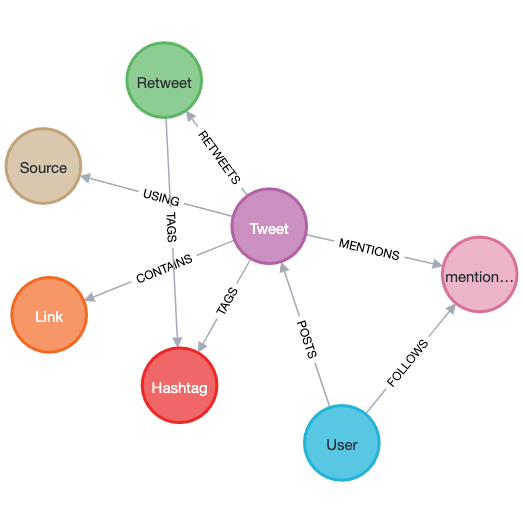

In [3]:
from IPython.display import Image
Image("graph_model.png")